# Age of Empires 2 player stats

## Retrieve the data from the api

In [1]:
import requests
import numpy as np
import pandas as pd

n = 1000

profile_id = 76561198141504553

resp_games = requests.get('https://aoe2.net/api/player/matches?game=aoe2de&steam_id=' + str(profile_id) + '&count=' + str(n)).json()
resp_games = [i for i in resp_games if ((i.get('num_players') == 2) & (i.get('name') == 'AUTOMATCH'))]

resp_ratings = requests.get('https://aoe2.net/api/player/ratinghistory?game=aoe2de&leaderboard_id=3&steam_id=' + str(profile_id) + '&count=' + str(n)).json()
resp_ratings = resp_ratings[:len(resp_games)]
resp_string = requests.get('https://aoe2.net/api/strings').json()
civs_str = resp_string.get('civ')
maps_str = resp_string.get('map_type')

players = [i.get('players') for i in resp_games]
players = [j for i in players for j in i]
players = [i for i in players if i.get('steam_id') == str(profile_id)]

other_players = [i.get('players') for i in resp_games]
other_players = [j for i in other_players for j in i]
other_players = [i for i in other_players if i.get('steam_id') != str(profile_id)]

civs = [i.get('civ') for i in players]
l_civs = []
for i in civs:
    l_civs.append([j.get('string') for j in civs_str if j.get('id') == i][0])
civs = l_civs

other_civs = [i.get('civ') for i in other_players]
l_civs = []
for i in other_civs:
    l_civs.append([j.get('string') for j in civs_str if j.get('id') == i][0])
other_civs = l_civs

maps = [i.get('map_type') for i in resp_games]
l_maps = []
for i in maps:
    l_maps.append([j.get('string') for j in maps_str if j.get('id') == i][0])
maps = l_maps

winlose = [i.get('won') for i in players]

df = pd.DataFrame({'Maps':maps,'Civs':civs,'Win/Lose':winlose,'Other player civ':other_civs})
df['Victories'] = np.where(df['Win/Lose']==1,1,0)
df['Defeats'] = np.where(df['Win/Lose']==0,1,0)
df['Counted games'] = df['Victories'] + df['Defeats']

df_agg = df.groupby(['Civs'])[['Victories','Defeats','Counted games']].sum()
df_agg['Winrate'] = df_agg['Victories'] / (df_agg['Victories'] + df_agg['Defeats'])

df_other_agg = df.groupby(['Other player civ'])[['Victories','Defeats','Counted games']].sum()
df_other_agg['Winrate'] = df_other_agg['Victories'] / (df_other_agg['Victories'] + df_other_agg['Defeats'])

df_maps_agg = df.groupby(['Maps'])[['Victories','Defeats','Counted games']].sum()
df_maps_agg['Winrate'] = df_maps_agg['Victories'] / (df_maps_agg['Victories'] + df_maps_agg['Defeats'])

def color_red_green(val):

    if val > 0.55:
        color = 'green'
    elif val < 0.45:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

## Winrate by civs

In [5]:
df_agg = df.groupby(['Civs'])[['Victories','Defeats','Counted games']].sum()
df_agg = df_agg[df_agg['Counted games'] > 1]
df_agg['Winrate'] = df_agg['Victories'] / (df_agg['Victories'] + df_agg['Defeats'])
df_agg.sort_values(by='Counted games',ascending=False)\
    .style.format("{:.0%}",subset=['Winrate'])\
    .applymap(color_red_green,subset=['Winrate'])

,Victories,Defeats,Counted games,Winrate
Civs,,,,
Magyars,6,9,15,40%
Vietnamese,7,8,15,47%
Vikings,7,8,15,47%
Malians,10,3,13,77%
Britons,6,4,10,60%
Berbers,4,5,9,44%
Italians,4,5,9,44%
Mayans,3,5,8,38%
Chinese,5,1,6,83%


## Winrate by civs against

In [6]:
df_other_agg = df.groupby(['Other player civ'])[['Victories','Defeats','Counted games']].sum()
df_other_agg = df_other_agg[df_other_agg['Counted games'] > 1]
df_other_agg['Winrate'] = df_other_agg['Victories'] / (df_other_agg['Victories'] + df_other_agg['Defeats'])
df_other_agg.sort_values(by='Counted games',ascending=False)\
    .style.format("{:.0%}",subset=['Winrate'])\
    .applymap(color_red_green,subset=['Winrate'])

,Victories,Defeats,Counted games,Winrate
Other player civ,,,,
Mongols,7,6,13,54%
Persians,6,5,11,55%
Britons,5,2,7,71%
Mayans,3,4,7,43%
Aztecs,3,4,7,43%
Cumans,4,2,6,67%
Huns,4,2,6,67%
Japanese,3,2,5,60%
Celts,1,4,5,20%


In [43]:
df_agg['Type'] = 'For'
df_other_agg['Type'] = 'Against'
df_merged = pd.concat([df_agg,df_other_agg],axis=0)
df_merged.index.name = 'Civs'
df_merged = df_merged.reset_index()
df_merged = df_merged.sort_values(by=['Civs','Type'])

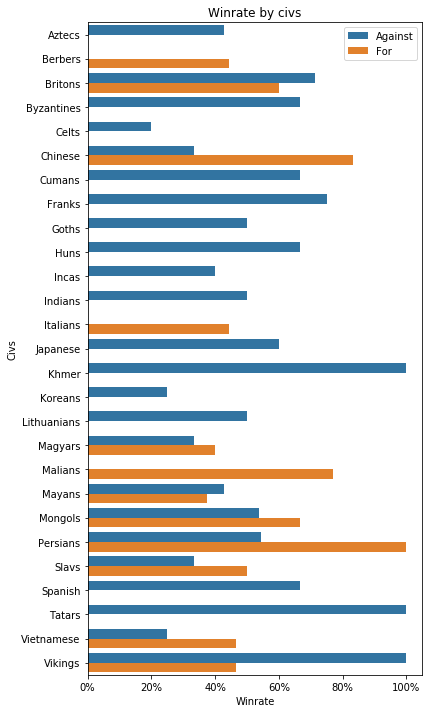

In [49]:
import seaborn as sns
f, ax = plt.subplots(figsize = (6,12))
sns.barplot(y='Civs', x='Winrate',hue='Type', data=df_merged)
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
plt.title('Winrate by civs')
plt.legend(loc='upper right')
plt.show()

## Winrate by maps

In [4]:
df_maps_agg = df.groupby(['Maps'])[['Victories','Defeats','Counted games']].sum()
df_maps_agg = df_maps_agg[df_maps_agg['Counted games'] > 1]
df_maps_agg['Winrate'] = df_maps_agg['Victories'] / (df_maps_agg['Victories'] + df_maps_agg['Defeats'])
df_maps_agg.sort_values(by='Counted games',ascending=False)\
    .style.format("{:.0%}",subset=['Winrate'])\
    .applymap(color_red_green,subset=['Winrate'])

,Victories,Defeats,Counted games,Winrate
Maps,,,,
Arabia,13,12,25,52%
Four Lakes,14,6,20,70%
Golden Swamp,8,5,13,62%
MegaRandom,3,10,13,23%
Serengeti,5,7,12,42%
Arena,2,6,8,25%
Hill Fort,3,3,6,50%
Nomad,3,2,5,60%
Acropolis,3,1,4,75%


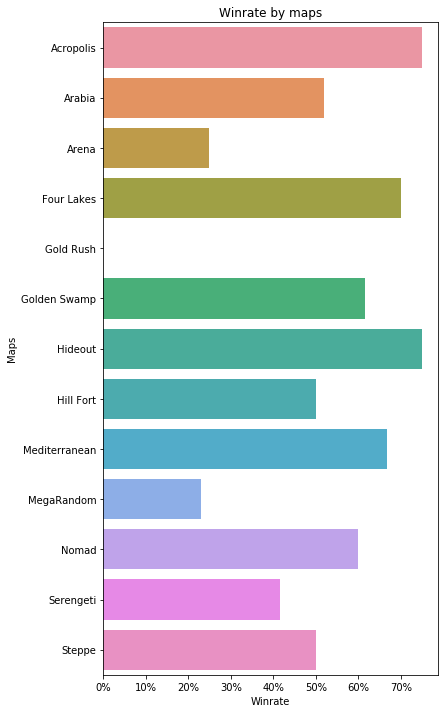

In [51]:
f, ax = plt.subplots(figsize = (6,12))
sns.barplot(y='Maps', x='Winrate', data=df_maps_agg.reset_index())
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
plt.title('Winrate by maps')
plt.show()